In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
try:
    df = pd.read_csv('Dataset/sqli-extended.csv')
    num_rows = len(df)
    print(f"The number of rows in the dataset is: {num_rows}")
except FileNotFoundError:
    print("Error: The file 'sqli-extended.csv' was not found.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except Exception as e:
    print(f"An error occurred: {e}")

The number of rows in the dataset is: 109518


In [3]:
print("Number of columns in dataset : {}".format(df.shape[1]))

Number of columns in dataset : 2


In [4]:
# Dynamically handling missing values without specifying row limits
for i in range(len(df)):  # Iterate through the entire dataframe
    if pd.isnull(df.iloc[i, 0]):  
        df.iloc[i, 0] = df.iloc[i, 1]  
    elif pd.isnull(df.iloc[i, 1]):  
        df.iloc[i, 1] = df.iloc[i, 2]  
print(df.isna().sum())
print(df.head())

Sentence    0
Label       0
dtype: int64
                                            Sentence  Label
0                      " or pg_sleep ( __TIME__ ) --      1
1  create user name identified by pass123 tempora...      1
2                                                29%      1
3  ' AND 1 = utl_inaddr.get_host_address  (  (  S...      1
4   select * from users where id = '1' or @ @1 = ...      1


In [5]:
df.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,29%,1
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
4,select * from users where id = '1' or @ @1 = ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109518 entries, 0 to 109517
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  109518 non-null  object
 1   Label     109518 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [7]:
# Convert 'Label' column to string and then check for non-numeric characters
df['Label'] = df['Label'].astype(str)
df = df[~df['Label'].str.contains('[a-zA-Z]')]
# Convert the 'Label' column to integers
df['Label'] = pd.to_numeric(df['Label'], errors='coerce', downcast='integer')
df['Label'] = df['Label'].astype('float32')
# Drop rows with NaN values in 'Sentence' and 'Label' columns
df = df.dropna(subset=['Sentence', 'Label'])
df['Label'] = df['Label'].astype('int')

In [8]:
# Check for NaN values after cleaning
print(df.isna().sum())

Sentence    0
Label       0
dtype: int64


In [9]:
df.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,29%,1
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
4,select * from users where id = '1' or @ @1 = ...,1


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Label,109518.0,0.523293,0.499459,0.0,0.0,1.0,1.0,1.0


In [11]:
counts = df["Label"].value_counts()
print(counts)

1    57310
0    52208
Name: Label, dtype: int64


In [12]:
df.duplicated().sum()

2088

In [13]:
df= df.drop_duplicates()
print(f"Numbers of Duplicated : " , df.duplicated().sum())

Numbers of Duplicated :  0


In [14]:
df["Label"].describe().astype("int")

count    107430
mean          0
std           0
min           0
25%           0
50%           1
75%           1
max           1
Name: Label, dtype: int32

In [15]:
df['Label'].isnull().sum()

0

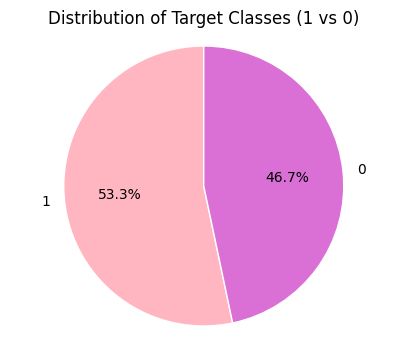

In [16]:
labels = df['Label'].value_counts().index
sizes = df['Label'].value_counts().values
colors = ['#FFB6C1', '#DA70D6']

plt.figure(figsize=(5, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(edgecolor='w'))
plt.title('Distribution of Target Classes (1 vs 0)')
plt.axis('equal') 
plt.show()

In [17]:
df['Label'] = df['Label'].astype(int)  # Labels are numeric
df['Sentence'] = df['Sentence'].astype(str)  # Ensure sentences are strings

# Concatenate sentences based on label
label_1_text = " ".join(df[df['Label'] == 1]['Sentence'].str.split().str.join(" "))
label_0_text = " ".join(df[df['Label'] == 0]['Sentence'].str.split().str.join(" "))

# Print lengths
print(f"Label 1 Text Length: {len(label_1_text)}")
print(f"Label 0 Text Length: {len(label_0_text)}")

Label 1 Text Length: 25729997
Label 0 Text Length: 23364926


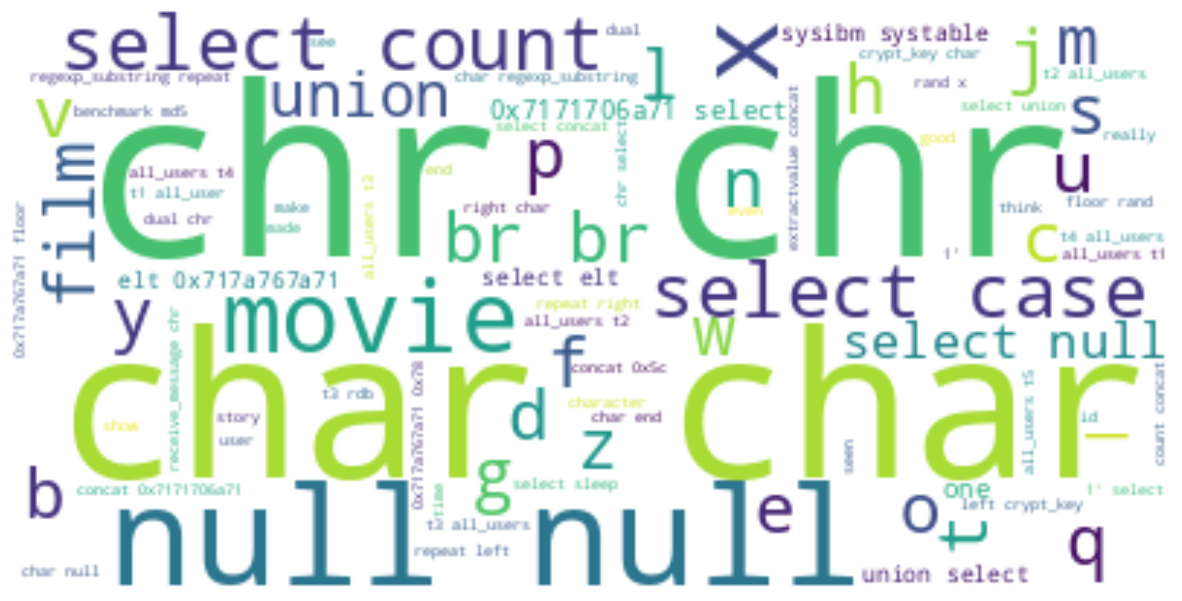

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#plot the worldcloud of label 1 queries
wordcloud = WordCloud(background_color = "white").generate(label_1_text)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

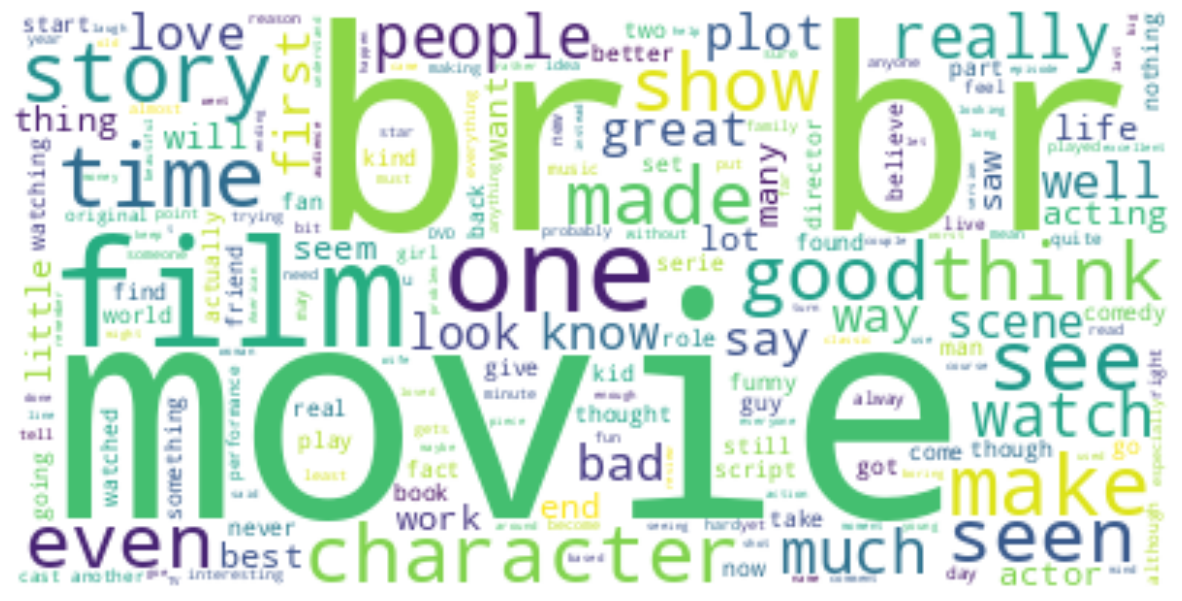

In [19]:
wordcloud = WordCloud(background_color = "white").generate(label_0_text)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [20]:
df.head(100)

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,29%,1
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
4,select * from users where id = '1' or @ @1 = ...,1
...,...,...
95,"select * from users where id = 1 or 1#"". unio...",1
96,"select * from users where id = 1 or 1#""; unio...",1
97,"select * from users where id = 1 or 1#""? or 1...",1
98,"""a"""" or 1 = 1--""",1


In [21]:
df["Label"].describe().astype("int")

count    107430
mean          0
std           0
min           0
25%           0
50%           1
75%           1
max           1
Name: Label, dtype: int32

In [22]:
categorical = [var for var in df.columns if df[var].dtype == 'O']

print(f"There are {len(categorical)} categorical variables")
print('The categorical variables are :', categorical)

There are 1 categorical variables
The categorical variables are : ['Sentence']


In [23]:
df.dtypes

Sentence    object
Label        int32
dtype: object

In [24]:
# Tokenization and Padding
max_words = 10000  # Only consider the top 10,000 most frequent words
max_sequence_length = 100  # All sequences will be padded/truncated to 100 tokens

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'])  # Learn word -> index mapping

# ✅ Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

sequences = tokenizer.texts_to_sequences(df['Sentence'])  # Convert sentences to sequences of indices
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [25]:
print("Original:", df['Sentence'].iloc[0])
print("Sequence:", sequences[0])
print("Padded:", padded_sequences[0])

Original: " or pg_sleep ( __TIME__ ) --
Sequence: [26, 430, 163, 98]
Padded: [ 26 430 163  98   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [ ]:
# K-fold Cross-Validation
k_folds = 10  
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize metrics
all_tp, all_fp, all_tn, all_fn = 0, 0, 0, 0
overall_accuracy = 0.0  

for fold, (train_index, test_index) in enumerate(skf.split(padded_sequences, df['Label'])):
    print(f"\nTraining Fold {fold + 1}")
    
    train_padded = padded_sequences[train_index]
    test_padded = padded_sequences[test_index]
    
    labels_train = df['Label'].iloc[train_index]
    labels_test = df['Label'].iloc[test_index]

    embedding_dim = 50
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
        Bidirectional(LSTM(256, return_sequences=True)),  
        Dropout(0.3),
        Bidirectional(LSTM(256)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Training
    model.fit(train_padded, labels_train, epochs=10, 
              validation_data=(test_padded, labels_test), 
              callbacks=[early_stopping])

    # Evaluate
    test_loss, test_accuracy = model.evaluate(test_padded, labels_test)
    overall_accuracy += test_accuracy
    print(f'Test Accuracy (Fold {fold + 1}): {test_accuracy * 100:.2f}%')

    # Confusion Matrix
    predictions = (model.predict(test_padded) > 0.5).astype("int32")
    cm = confusion_matrix(labels_test, predictions)

    tp, fp, fn, tn = cm.ravel()
    all_tp += tp
    all_fp += fp
    all_tn += tn
    all_fn += fn

# Average accuracy
overall_accuracy /= k_folds
print(f'\nOverall Accuracy Across all Folds: {overall_accuracy * 100:.2f}%')


Training Fold 1
Epoch 1/10
3022/3022 [==============================] - 158s 49ms/step - loss: 0.1094 - accuracy: 0.9704 - val_loss: 0.0825 - val_accuracy: 0.9780
Epoch 2/10
3022/3022 [==============================] - 143s 47ms/step - loss: 0.1100 - accuracy: 0.9720 - val_loss: 0.0892 - val_accuracy: 0.9785
Epoch 3/10
3022/3022 [==============================] - 187s 62ms/step - loss: 0.0868 - accuracy: 0.9769 - val_loss: 0.0757 - val_accuracy: 0.9777
Epoch 4/10
3022/3022 [==============================] - 224s 74ms/step - loss: 0.0640 - accuracy: 0.9805 - val_loss: 0.0725 - val_accuracy: 0.9805
Epoch 5/10
3022/3022 [==============================] - 243s 80ms/step - loss: 0.0601 - accuracy: 0.9814 - val_loss: 0.0754 - val_accuracy: 0.9796
Epoch 6/10
336/336 [==============================] - 16s 47ms/step - loss: 0.0725 - accuracy: 0.9805
Test Accuracy (Fold 1): 98.05%
336/336 [==============================] - 18s 45ms/step

Training Fold 2
Epoch 1/10
3022/3022 [===================

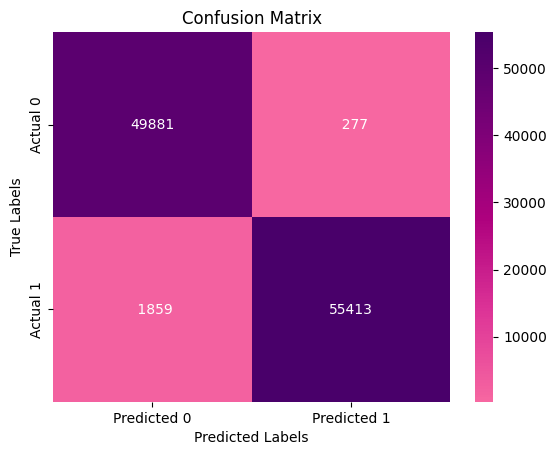

3358/3358 [==============================] - 156s 47ms/step

Average Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     50158
           1       1.00      0.97      0.98     57272

    accuracy                           0.98    107430
   macro avg       0.98      0.98      0.98    107430
weighted avg       0.98      0.98      0.98    107430



In [27]:
all_tp = int(all_tp)
all_fn = int(all_fn)
all_fp = int(all_fp)
all_tn = int(all_tn)

cm = pd.DataFrame(
    data=[[all_tp , all_fp ], [all_fn ,all_tn ]],
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)


sns.heatmap(cm, annot=True,  fmt='5', cmap='RdPu', center=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print average classification report
average_classification_report = classification_report(df['Label'], (model.predict(padded_sequences) > 0.5).astype(int))
print(f'\nAverage Classification Report:\n{average_classification_report}')

In [28]:
model.save("sql_injection_detection.h5")
print("Model saved to sql_injection_detection.h5")

Model saved to sql_injection_detection.h5


In [ ]:
def predict_sentence(sentence, model, tokenizer, max_sequence_length):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    binary_prediction = (prediction > 0.5).astype("int32").flatten()[0]
    return binary_prediction

# Example usage:

# input_sentence = 'select * from users where id = 1 or 1#" ( union select 1,version ( ) -- 1'
input_sentence = 'hello'
predicted_label = predict_sentence(input_sentence, model, tokenizer, max_sequence_length)

if predicted_label == 1:
    print("The model predicts a positive label.")
else:
    print("The model predicts a negative label.")

1/1 [==============================] - 1s 642ms/step
The model predicts a negative label.


In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

model = load_model("sql_injection_detection.h5")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

max_sequence_length = 100  


def predict_sentence(sentence, model, tokenizer, max_sequence_length):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, 
                                    padding='post', truncating='post')
    prediction = model.predict(padded_sequence)[0][0]
    binary_prediction = int(prediction > 0.5)
    return binary_prediction, float(prediction)

if __name__ == "__main__":
    query = input("Enter SQL query: ")
    label, confidence = predict_sentence(query, model, tokenizer, max_sequence_length)

    if label == 1:
        print(f"⚠️ SQL Injection Detected! (Confidence: {confidence:.2f})")
    else:
        print(f"✅ Query seems Safe. (Confidence: {confidence:.2f})")


1/1 [==============================] - 1s 1s/step
⚠️ SQL Injection Detected! (Confidence: 0.98)
